<a href="https://colab.research.google.com/github/starboysfy/thesis/blob/master/CSCI5525_Hw2_ModelingTutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#CSCI 5525 HW2_modeling Spring 2022
# Prof. Paul Schrater

The goal of this homework is to provide a concrete but challenging tutorial will probe and deepen your understanding of how to set up Machine Learning problems from fundamental concepts seldom articulated and taught.  This is an attempt on my part to fill a perceived gap in ML training.

The problems below address:


1.   Problem formulation: Function spaces and Objectives
2.   Problem solutions: Optimization, problem refactorization, and computation
3.   Theory: Machine learning has natural limits

In a second tutorial posted separately, we will explore
    a. Learning is optimization. 

    b. Optimization incurs costs and generates trade-offs
        * **Bias-Variance Trade-off**: Function space capacity and out-of-training-sample (OOTS) performance 
        * **Search Complexity/Data Size**: Flexible Function spaces need more data to constrain the freedom. Interpolation vs. Extrapolation create qualitative different trade-offs. 


# Part 1: Problem formulation (50 points)
In this multipart guided exercise we will explore how to form complex  objectives, then use these objectives to connect function spaces and data through optimization.

##**Objectives**:  
Objectives are usually challenging to characterize as a single function.  However, we can often may the objective concrete by turning it around. 

> Don't ask "what is the objective".

> Instead ask **what conditions satisfy or violate the objective?**

 You can often intuit and specify a set of constraints that must be satisfied for the objective to be achieved.  There are three typical motifs in formalizing these constraints:  
 1. **Identify constraint domains** which is equivalent to having either equivalence class relations OR equivalence class relations induced by being part of the shared domain of constraints.  
 2. **Expressing constraints as indicator functions** You can use truth-valued operators (e.g. == or ≥) to rapidly know how to create indicator functions, then substitute these for equivalent but differentiable versions. Once we have our constraints encoded as indicator functions, 
 3. **Form overall objective** by combining constraints according the the logic of the objective.

> _Example: Let's take on a real-world example. We will try to determine an objective for a challenging problem: characterizing a healthy diet. This is a really complex problem and ML could definitely help.  If you want to see some of the complexity look at https://bmcpublichealth.biomedcentral.com/articles/10.1186/s12889-019-6872-4

> First let's get the easy english version of our objective. 
```
Our objective is to maintain a healthy diet
```  
> Hopefully you are confused.  What single function can specify that? Is it even possible?? Before you give up, a few internet searches reveals that there is widespread agreement that a healthy diet involves: 
* **Constraint type 1:** _average calorie target_ 
which ensures our food intake maintains an average calorie target based on how much we exercise.  
* **Constraint type 2:** _macronutrient constraints_ 
there are three big categories of nutrients, proteins, fats and carbohydrates, and each category has a typical calorie amount.
* **Constraint type 3:** _micronutrient constraints_ there is a long list of amino acids, vitamins, fatty acids, and minerals that we need to regularly consume, and these need to live within both minimum and maximum requirements.
* **Constraint type 4:** _non-nutrient contraints_ there are components of foods like fiber and allergens that we need to both include and exclude, and these vary from person to person.

### Constraints are functions on variables
> One of the most important shifts that happened when we switched to the constraint view is that we are much closer to formalizing our ideas in machine learning terms - as a set of functions.  In this assigment and tutorial, I am using the concept of constraint that we study in convex optimization, but viewed more generally as a function that maps data and ML parameters into a measure of how well one of our component objectives is satisfied (e.g. every data point is correctly classified).   

#### `Types of constraints`

Although there are many complex constraints we can formulate, a very large class of constraints can be made by combining two motifs:  

* **Equivalence class constraints**-- _enforce equivalences or distinctions_:  these constraints create natural categories and concepts, and they allow for computational rewrites, reductions and translations by substituting in equivalent forms.  Classification is the prototypical example. For domains where the elements can be represented using set theory, equivalence classes can be always be characterized in a canonical form as a computable function that returns zero whenever inputs belong to the class.

    * _Canonical Functional form_:  
    {$ x | h(x) = 0, \text{ for some  } h $} 

* **Order constraints**-- _enforce orders_: Order constraints emerge in domains where we have containment, natural notions of magnitude, size, amount, precedence (time, causality), or preferences. Because order constraints often involve comparisons between data points or parameters, they often require inputting pairs of inputs, so that the natural canonical form is best expressed as:

    * _Canonical Functional form_:  $\bf{x}$ = {$(x_i,x_j)| g({\bf x}) < 0 $}

#### `Combining and Rewriting constraints`
> If we need to combine constraints, then we are usually doing logic, either explicitly or implicitly.  Logical combinations of constraints are aided by the fact we can rewrite our constraint functions in terms of [`indicator functions`](https://en.wikipedia.org/wiki/Indicator_function) that test whether the constraint is satisfied. These functions can also be constructed by transforming the canonical forms above, using any math operations that force the range of the constraint functions into a desired form.  Indicator functions are often easier to explicitly rewrite down. We know it will take as inputs all the variables that impact whether the constraint is satisfied/violated, and return a value that we can interpret as satisfied or violated.  The two most important classes of constraint functions return either _Boolean_ (binary) or _Positive_ values to indicate the constraint is satisfied/violated.  
>> _Logic form_: $$y_k = i_{k}(z) \in \left[0,1\right]$$
>> _Penalty/cost form_: $$d_{m} = h_{m}(z) \in \left[0, \infty^+\right)$$
>> Moreover these two constraint forms have a standard rewrite rule we use everywher in ML:
>> $$y = \exp(-d) \Leftrightarrow d = -\log(y)$$

>> **Combining constraints**: The most common cases are that we want to AND all the constraints, so that they all need to be satisfied, or we have multiple distinct scenarios involving subsets of ANDed contraints and we OR these scenarios together.  Indicator functions make expressing constraint combinations logically easy to implement. Recall that if we have two logical statements $A$ and $B$, then the logical and can be computed using Boolean algebra.  In terms of indicator functions, $A \wedge B = (y_A*y_B)$, and $A \vee B = min(y_A + y_B,1)$, which is also $= 1-((1-y_A)(1-y_B))$. 

>>Other operators like XOR can be approximately by a convex combination of the two indicators, like $\alpha y_A + (1-\alpha) y_B$, for $\alpha \in [ 0, 1]$, and XOR also oftens appears as a product with powers $y_A^a y_B^{(1-a)}$, introducing a variable $a$ that represents which constraint, A or B is active. The standard Bernoulli likelihood is constructed this way. These logical constructions appear everywhere in Machine Learning, usually without explaining where they came from.  

>>There are two facts from logic that are often lurking behind the scene. One is that all simple compound logical expressions involving only conjunctions and disjunctions can be written in two logically equivalent, but computationally different forms: _conjunctive normal form_ and _disjunctive normal form_ (see [canonical normal form](https://en.wikipedia.org/wiki/Canonical_normal_form)).  

>>What these forms mean is that we can group the terms in our logical expressions by grouping conjunctions together first, then disjunctions: (A and B and C) OR (D and E) ...; or grouping disjunctions together first, then using conjunctions on the groups: (A' or B' or C') AND (D' or E'). Because OR creates an equivalence class over constraints in a group (if any of them are satisfied, the group is too), and functions that compute equivalence classes are relatively easy to implement in machine learning (they are classifiers), most machine learning architectures use conjunctive normal form to structure objectives.  First we group constraints into classes, then we link these together by anding. 

>>If we introduce intermediate logical variables $z_{ij}$ for equivalence classes of ORed constraints, $y_i = \sigma(\sum_j z_{ij})$ where $\sigma$ is a squashing function like [heaviside](https://en.wikipedia.org/wiki/Heaviside_step_function) or [logistic](https://en.wikipedia.org/wiki/Logistic_function) that goes from zero to one, then the OR over $j$ of a group $i$ of indicator variables $z_ij$ takes a familiar ML form.  The conjunctive normal form recipe for combining constraints is:
* **Step 1**: Compute indicator functions for all component constraints $z$
* **Step 2:** Identify and group the components into sets of components $j \in J_i$ for group $i$. Now combine constraints within groups using OR, which can be computed as: 
$$y_i = \sigma(\sum_{j \in J_i} z_{ij})$$ 
* **Step 3:** Form an overall constraint objective 
$$I_{\bf y} = \prod_i y_i$$
>> _NOTES:_ 
If you take the log of $I_{\bf y}$, you convert it into a sum.  More importantly it takes on a good mathematical form to combine with other loss-type objectives.  
\begin{align}
L_{\bf y} & =  -log I_{\bf y} \\
& =  \sum_{i} \lambda_i \log y_i({\bf x}) \\
 & = \sum_{i} \lambda_i \log\left( \sigma\left(\sum_j y_{ij}\right) \right)
 \end{align}
That converts the conjunctive normal form combined constraints into a Lagrangian friendly form, that sums over the grouped constraints in penalty-format.  Incorporating weights $\lambda$ then allows representing the relative value of satisfying each constraint group.  


>> **Constraints induce data needs:** One of the most important things to notice is that decomposing the objective into constraint functions creates _input_ requirements: each constraint will require certain information to evaluate it, and if that information is not available it will be uncertain.  Our data may or may not have the required information, but we can introduce vectors of variables ${\bf y_i}$ for each constraint $i$ that represent the required input.

>> Let  ${\bf y_i}\in\mathcal{R^{N_i}}$, for all $i \in \mathcal{C}$ in the set of constraints represent variables that are defined __by the constraints__, and not our data. To form these variables we need to find a set of functions that convert our data to a form better suited to evaluate the constraints. This creates a ubiquitous representation learning problem.
* **Representation Learning**:  Find a set of functions $\phi$ such that
$$\phi_{ij}: {\bf X}\rightarrow {\bf \hat{z}_{ij}}$$

>> **Expectations** Our constraints are unlikely to be fully satisfied by real data.  Instead we can optimize over the expected value of the constraint outputs. Moreover, if our data is incomplete to fully evaluate these functions, we will need to take an _expectation_ over the missing information. the constraints to average over uncertainty  need to transform our data variables to a form suitable for testing our constraints.
Taking expectations over constraints in indicator function form has an important connection with probabilistic reasoning--the expected value of an constraint indicator function is the probability the constraint is satisfied:
$$ \mathcal{E}_{X}[y_k(X)] = Pr(y_k)$$

>At this point our efforts to unpack the process of forming objectives have provided deep connections to core ML concepts and methods, connecting the core probabilistic, heuristic and functional components as ingredients. These ingredients are ubiquitous computations needed to check constraints, and by pulling these computations together we form a machine that can construct functions which satisfy complex objectives.

> As the preceding discussion is quite abstract, let's ground it in example 1.


####Example 1 cont'd: 
Let's go back to our steps.  We have expressed our goals in terms of nutritional constraints, but now we need to do _Step 1: What are the domains of our constraints?_.  Given the discussion above, the domains are nutrients and non-nutrients.  But that doesn't quite help, because we also learned that constraints create equivalence classes over possible inputs, and we know we will be eating foods, but the information on nutrient list is not included on the foods we buy or grow. We need to be able to relate our nutrients to both **foods** and **data**, and we need to create variables which can relate foods, constraints and variables. Let's start thinking about these variables. 

**What are the natural Z variables for nutrient constraints?** 
Our literature review discovered a a set of nutrients we need to ingest within specified ranges.  Now nutrients are composites--a nutrient refers to a [collection of chemical compounds](https://chem.libretexts.org/Courses/Brevard_College/CHE_301_Biochemistry/07%3A_Nutrition/7.01%3A_Nutrients) that has some biological purpose. Thus [`nutrient`](https://en.wikipedia.org/wiki/Nutrient) is a label for groups of chemical compounds with the same biological impact.  In other words, a nutrient is an equivalence class.

**Natural variables are composite**: One of the reasons I selected this problem is that it illustrates an incredibly common Machine Learning problem.  The natural variables for a problem are usually composites, and the data we receive are _also_ composites, but not usually in the form we want them.  In fact, the basic constituents underlying our data, like the atoms and molecules in our foods may come grouped in many different ways in our data, our linguistic labels, the way we tagged and encoded things, and through co-occurring in the events when we captured our data.  That means we should expect that our data and objective variables are both composites but unlikely to be in correspondence, and we will need to discover the mapping that translates between these composites.  This justifies the ubiquitous need for complex data transformation and representation learning.  What kinds of different composites do we have in our data?  THREE!

> **Nutrients as Chemical Composition Labels**: Our constraints are defined through nutrients, which are just labels on equivalence classes of chemical compounds.

> **Foods as Chemical Composition Labels**: In our internet search we learn that different raw foods, plant and animal products like fruits, vegetables, nuts, legumes, grains, milk, meat, fish, etc. each have complex mixtures of the nutritional components in our constraint list, as well as components NOT in the constraint list. Thus foods are characterized by substitutable groups of related chemicals that form nutritional and non-nutritional _equivalence classes_.  

> **Measurements as Chemical Compositions**:  We will also find that any measures we can get for our nutrients will not fully match the  nutrient constraint classes, and that our measures will usually overlap and also fail to measure or distinguish chemical compounds needed to assess nutrient constraints. Thus expect your data to express its own _equivalence classes_ of chemicals. 

> **Understanding Composite Data Structures: Matrices, weighted incidence graphs, etc.**
A useful way to understand a composite is to make a _composite by component_ table, which is also a useful data structure. Here we do not know what the most useful components are, but we want them to be shared between foods, data measurement and constraints.

| Composite Name\Components | c1 | c2 | ... |
|---------------------------|----|----|-----|
| Vitamin A | z11 | z12 | ...|
| FattyAcid 237| z21 | z22 | ...

which produces a set of row vectors for each composite.  There are three composites of interest, so I usually create notation that allows me to know these are the same type of thing, but also help me remember distinctions.  Let's call the _latent_ component representations of foods, nutrients and data measures:
* **Nutrients:** The $j^{th}$ nutrient is assigned $z_{N_j} \in \mathcal{R}^{L}$, and the full set of $I$ nutrients to a matrix ${\bf Z}_N \in \mathcal{R}^{I \times L}$

* **Foods:** The $j^{th}$ nutrient is assigned $z_{F_j}\in \mathcal{R}^L$ and the full set of $J$ foods the matrix ${\bf Z}_F \in \mathcal{R}^{J \times L}$ 
* **Data Measures:** The $j^{th}$ data measure is assigned $z_{D_j} \in \mathcal{R}^L$ and the full set of $M$ _measures_ (e.g. features) ${\bf Z}_D \in \mathcal{R}^{M \times L}$

Note that $L$ is the size of our shared latent space, i.e.the number of components.   

**What is our data?**
> Finally, we find a new wearable device we can purchase for only 75 that can monitor our body and return error-prone measures that tell us every 12 hours our:
* **Macronutrient totals:** the total grams of fat, protein, carb 
* **Caloric excess/deficit:** $\Delta Cal$ the device's estimate of how many calories in excess or deficit.  If the device is accurate the ideal is zero, and there is a typical range of +/-200kCal
* **Chemical profile:** ${\bf X}$ a long list of the amounts of lots of complex-looking chemical names we don't know how to perfectly match up to any of our constraints, but the leaflet in our device proudly states that it covers all micro, macro, mineral, and non-nutrient categories, metabolites, and more.  
* **Imbalance detectors:** ${\bf q}$ a four number aggregate measures that is supposed to indicate deficits or excesses in four categories: `fiber`, `aminos`, `vitamins`, `toxins`, all of which are ideally zero, but are positive if there is a problem, indicating you have deficits in the first three, or an excess of toxins (e.g. non-zero means you need [more, more, more, less]).
> You also join a slack group of health enthusiasts who are all logging their diets in terms of all the meals they ate over 12 hours (described as lists of basic food names with quantities of each) together with the device readouts. The records for a single person for a single day look like: 


|Meal or measure           | ∆Cal | Protein | Fat | Carb | X1 | X2 | ...
--------------------------|------|-----|-----|------|----|---|---| 
1,List={(Apple,100g),etc}| .    | .   | .   | .    | .  | . |
2,List={(Tofu,200g),etc}| .    | .   | .   | .    | .  | . |
3,List={(Rice,400g),etc}| .    | .   | .   | .    | .  | . |
4,List={(Apple, 100g),etc}| .    | .   | .   | .    | .  | . |
5,Measure={day,time}| +230kCal | 62g  | 34g   | 52g  | 321mg  | 21 mg | ...


This might be enough information to try to build a smart system, but it's still unclear what we really want to do. The way the food lists are shaped isn't machine learning friendly though.  
> So we `preprocess` the foods by:
* Creating an alphebetical list of all unique food items, a list of size $J$.
* $\bf{f}$: Make a _consumption vector_ of the daily amounts (grams) consumed of the foods in the list.  
> For simplicity, we don't include foods that might be wonderful but that we have no data on -- that would create a much harder problem.  With this assumption all observed daily food comsumption can be described as an $J \times 1$ vector $\bf{f}$ with zeros for all foods not consumed.




### PROBLEM FORMULATION
The problem we want to solve is getting clearer now.  We want to provide a daily list of foods and amounts that meet a person's individual needs, given the measures from the device. To be a machine learning problem, we need to recast this problem as: 
_find a function that takes in data, and learns how food vectors meet nutritional needs_.  

More generally, we might want to give users _food advice_: We might want to input measures from the device, and return a food vector that best balances the diet. 

Problem formulation is very difficult without diagramming the function we want to create--focusing on the required input and outputs needed to accomplish our goal, and articulating all the things we know from the domain. 


We have a set of _Knowns_: 
* **Relations**: All chemical compositions relationships can be expressed as linear combinations of component amounts. Any composition of chemicasl amounts can be mapped to another using a linear transformation.  For example: 
   - $z_f = W_F \, {\bf f}$
   - $z_t = W_D \, {\bf x}$
   - $z_n = W_N \, {\bf z}$

* **Inputs**: We have two measures of a person's nutritional state that we can use to determine whether all the constaints and objectives are met:
   - ${\bf x}$: the measured chemical profile
   - ${\bf f}$: the foods consumed
* **Targets**: We have a list a nutrients that need to be kept in range, calories and health imbalance indicators in range and macronutrients in target proportions.
   - ${\bf y }$,${\bf t}$ 

Let's restate our basic problem in more formal terms. 

* **Assumptions:** Given nutritional, caloric and non-nutritional constraints on food consumption, and data in the form of vectors that describe foods consumed, calorie excess/deficit, macro intake per 12 hour, and a measured consumption chemical profile: 
$\mathscr{D} = \left\{\bf{f} \in \mathcal{R+}^n, t \in \mathcal{R}^s,\bf{X} \in \mathcal{R}^m \right\}$, and constraints $\{ \mathtt{nutrient}_1,\cdots, \mathtt{nutrient}_K \}$ 
* **Goal**: Find daily diets $\mathbf{f}$ that satisfy nutritional constraints and optimize target values.  
* **Objective Function**:  To learn relatiionships, minimize an objective function 
$$ \mathscr{L} = \sum_l \lambda_l L_t(t_l) + \sum_k \lambda_k L_y(y_k)$$ 
over parameters where $L_t$ and $L_y$ represent loss functions that encode target and constraint objectives. This loss objective has the right form, but we will need to determine the function.
 

#PROBLEM SOLUTION

Having formulated a problem, there are a typical set of steps that you can follow that help structure finding a solution.  These steps have been used by thousands of students in my summer schools over the last decade to develop full and orginal ML models of complex phenomena in less than two weeks.

## DEFINE ALL VARIABLES

Let's collect all the information into a list, ensuring we identify which parts of our data form inputs and targets. We also dentify our natural latent variables and introduce loss variables that represent how our objective can be optimized.  

###Inputs
* **Data Inputs**: ${\bf x_f} = \left[{\bf x, f} \right]$ (device chemical profile, foods consumed)

###Latents
* **Latent Variables**: ${\bf z} = \left[{\bf z_{D_j}, z_{F_j}, z_{N_j}}\right]$ (conversion to shared components)
* **Constraint Variables**: ${\bf y} = \left[ i_1({\bf z_{N}}) \cdots i_I({\bf z_{N}}) \right]$ the set of binary indicator functions for all our nutritional constraints.

###Targets and Losses
* **Target-Variables (Data-related)**: ${\bf t} = \left[{\bf \Delta Cal, ∆m, q} \right]$ ( variables that have ideal target values that we can set to zero) 
* **Loss Measures**: ${\bf L} = \left[ L_y, L_t \right]$ ( measures that encode the objective )

Notice that our constraints did NOT get listed under targets.  That's because we do not currently have data that gives us measures of the nutrient levels in a 12 hour period.  So we have a common modeling choice.  We could a) ignore the the nutrient constraints because we have no measures (common but not really acceptable) b) treat this as an unsupervised learning problem c) hope that some of the measures we have could help us learn whether our constraints are satisfied.  I will try to get you to use approach c, to help illustrate modeling principles.

## FIND EQUATIONS RELATING VARIABLES 

In well-defined ML problems, we can use our problem understanding to connect variables using functions.  These functions should encode our essential knowledge while providing parameters that allow for learning. The dominant ML paradigm is use three ingredients
* Linear weights on inputs
* Non-linear ``activation functions`` applied to weighted inputs
* Structured composition of these linear/non-linear function layers that provide a surprisingly expressive computing framework.  

Understanding how to put together these functions feels mysterious until you develop a vocabulary of basic functions, and how to compose these to achieve particular results.  One powerful way to gain intuition is to understand how to convert ML equations into approximate logic - which helps to both to create new architectures and to understand why some computations work better than others.  That said, there is not a unique way to construct or interpret most ML models, so the goal of this exercise is to give new and powerful intuitive tools to make your own ML solutions by ensuring you can create models that faithfully reflect your hypotheses and understanding.

### Use graphs connecting natural inputs and outputs to understand what functions we need to make

We know that 
* inputs -> latent 
* latent -> targets
in every supervised learning model.  Currently our domain knowledge has helped us know that there will be $z$ variables for foods, device chemical measures, and for nutrients.  However, although we know the list of nutrients needed and may know something about them, we don't get to measure them.  Therefore $y$ are also latent.  If we want our nutrient constraints to have a teaching signal, we can hope that nutrient deficiencies might create signals in the ``imbalance`` measures that the device does measure.  That suggests we also connect our constraint variables to the imbalance detector targets.

Let's construct a graph representing one model for how to form these connections.  In the below I assume we still have two loss functions, and will use the $q$ component of the target vector $t$ to train our nutrient constraint functions.   


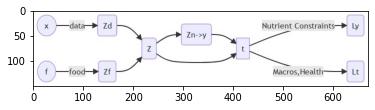

1 _Formulate all constraint and objective equations_
  * _Constraint/Objective function domains--_: identify the domain of each function. If the constraint isn't global, your equation will need to select  which variables and/or ranges of values of these variables which are to be included. Indicator functions are special -- they only have two output values. This means that the domain of each indicator function is partitioned into two regions.  
    * **Selection functions**: A standard ML form for a function that determines which components $x_k$ of $\bf{x}$ are in a region is to use a binary component classifier: $$a_k = \mathtt{Logistic}\left( x_k \right)$$ which creates a vector the same size as the input vector ${\bf a} = \[ a_1, \cdots a_N \]$ that represents whether $x_k$ is in the domain of the `1` region of the indicator function. These functions normally have separate parameters for each indicator. The `0` region is just $1- {\bf a}$.  This construction is often termed **attention**.
    * **Domain representation**: A simple representation of the domain is then $${\bf a\odot x}$$ the `pointwise` product of two vectors (e.g. $[a b c]\odot [d e f] = [a d, b e, c f]$). 
  * _Range representation--Nutrients_: When a constraint function has a domain in ${\bf x}$, the selection function **is** an indicator function.  However, Constraint functions may first aggregate (OR) over multiple regions that are logically sufficient, and the domain of the constraint may not be covered by our data. In our discussion of constraints, we introduced the idea of aggregating (OR) over the domains that are constraint equivalent.  If we allow for missing values, we get a general form for a constraint indicator function equation:    $$y = \mathtt{Softmax}\left(\sum_{j} w_j a_j(x_j) x_j \right)$$ that represents the probability the constraint is satisfied given data. The additional weights $w_j$ account for unequal importance of the $x_j$ components, and allows combined effects of multiple components and sets uncertainty for missing components. 
  * _Range representation--target objectives_: the range of loss objectives should be from 0 to infinity, with larger meaning worse. We have Calorie and Macro target objectives that we can express as differences away from an ideal value - that suggests a simple squared error or absolute value loss function. The imbalance/toxin detectors given by the device are already loss measures, so we could just weight them in directly. However, we also want to use them to train our nutrient constraints.  To do that we can try to _predict_ the imbalance measures from the outputs of a set of nutrient satisfaction indicators.  This is a more sophisticated kind of ML reasoning, and if you get used to the logic, it's an extremely common kind of reasoning used to justify ML designs.  We we unpack this reasoning in the problems below.   

2 _logically combine all equations and convert into a ``loss`` form_: Given a set of component loss functions and constraint functions, we need to combine them.  We also saw how to combine loss functions using Lagrangians. How to combine our constraints?  Well that depends on how the constraints are related to each other, and how we incur losses due to violations.  If you have multiple constraints, combine logically.  How to do that?  A practical method for understanding what to do is ask a few key questions. Ask:
* How many constraints have to satisfied?  
   - MOST -> combine using AND
   - ANY -> combine using OR
* Do the constraints depend on each other?
  - NO -> treat them as independent
  - YES -> model the dependence. Determining dependencies between constraints airwise is simplest and often enough.  For example if constraint A can only be satisfied if constaint B is satisfied, then we develop a conditional model.
* Loss form
  - if constraints return [0,1], with 1 being satisfied, then use -log to transform to loss form.  If the constraint measure is monotonic increasing with violations, then it is in loss form. 
  
3 Form Lagrangian and optimize over free variables. This is the final step. 
  

#Problem 1, part 1 (10 points) Understanding objective functions-- one constraint
In this quasi-tutorial problem, the goal is to use the following table to help write down an objective function family for our nutritional constraints. We start with developing a template.  Here's the problem: 
* Given a chemical profile vector ${\bf x}$ and the $n^{th}$ nutrient type (e.g. ``vitamin B12``), write down a parameterized function $\phi: {\bf x} \rightarrow y$ that returns 1 if the nutrient is within a range, and zero otherwise.  
* Assume that there exists some ${\bf w_n}$ such that $z_n = {\bf w_n}^t {\bf x}$ gives the amount of the $n^{th}$ nutrient in grams, _and_ assume that the need is satisfied if $z_n$ is above a minimum amount $w_n^{0-}$ and below a maximum amount $w_n^{0+}$.  
Your answer should take the form of a specific equation of the form
$$y_n = f_n({\bf x},{\bf w_n},w_n^{0-},w_n^{0+})$$


#Problem 1, part 2 (10 points) Understanding objective functions-- combining multiple independent constraints.

Assume you have made a set of functions $f_1, ... , f_n$ that return a vector ${\bf y} = [y_1, ... y_n]$ that take on values of 1 or 0 if the constraint is satisfied or not.  For this problem we will parameterize logic using tricks from Boolean algebra and neural networks.  Using only simple functions $g()$ of $y_i$ (e.g. $g(y_i) = \log(y_i)$), weighted sums with weights $\omega_i$: $\sum_{i=1:K} \omega_i \, g(y_i)$ and softmax, we want to write down functions that approximate:

* The requirement that all $y_i$ are satisfied: $y_1 \vee \cdots \vee y_n = True$
* The requirement that at least one or more $y_i$ are satisfied: $y_1 \wedge \cdots \wedge y_n = True$

A key neural network trick is to use approximate truth tables and the following map between logic and probability:

* NOT $y_i \leftarrow  1-y_i \approx 1-p(y_i)$
* $y_1$ AND $y_2$: $y_1 * y_2 \approx p(y_1)p(y_2)$
* $y_1$ OR $y_2$: $y_1 + y_2 \approx \min(1,p(y_1)+p(y_2))$

and this logistic "trick".  Let $z_i = \log(y_i)$. The joint probability $p(y_1,y_2|x) = \frac{e^{(\omega_1 z_1 + \omega_2 z_2 - \omega_0)}}{1+e^{(\omega_1 z_1 + \omega_2 z_2 +\omega_0)}}$ can approximate both AND and OR truth table for appropriate values of $\omega_0$ and $||{\bf \omega}||$.

Use these ideas to answer these questions:
* Find values of the parameter vector ${\bf \omega}$ such that the following $(y_1, y_2)$ points approximately map to the indicated values.
    - $(0,0) \rightarrow 0,(0,1) \rightarrow 0, (1,0) \rightarrow 0,  (1,1) \rightarrow 1$  
    - $(0,0) \rightarrow 0,(0,1) \rightarrow 1, (1,0) \rightarrow 1,  (1,1) \rightarrow 1$ 
    - HINT: $\omega_0$ is important to set, the other parameters just need to be large enough.
* Generalize the two component equation to allow for $N$ components and use that to derive $\omega$ parameter combinations that can approximate the two requirement conditions listed above.

The point of this problem is to show you that a simple logistic function with weights can parametrically express a large range of approximate reasoning.


In [ ]:
k

#Problem 1, part 3 (10 points) Understanding objective functions-- combining multiple dependent constraints.

This sounds much harder, but it's really not.  Dependent contraints means that one constraint requires another to be satisfied (or excluded) before it can be satisfied.  The trick here is very similar however.  Conditional probabilities can model lots of dependencies, and we just need to learn how to parameterize them.  Let's take two cases.  Constraint 2 can only be satisfied if constraint 1 is satisfied.  That means that we need to create a function so that $y_2$ is only 1 if $y_1$ is approximately 1.  We will exploit what we learned in the last problem and see if we can reuse the logistic function.  

> Note that $p(y_2|y_1) = \mathtt{logistic}(\omega_2 z_2 + (y_1 - 1) + \omega_0)$ will shift the function such that the probability of $y_2$ is low unless $y_1$ is true.  Second notice that this function is composed with the function that produces $y_1$. This suggests replacing $y_1$ with $p(y_1) = \mathtt{logistic}( {\bf \omega_1}^t \left[{\bf x}, 0 \right]$):
$$ $p(y_2|y_1) = \mathtt{logistic}\left(\omega_2 z_2 + \omega_0' + \mathtt{logistic}({\bf \omega_1}^t \left[{\bf x}, 0 \right]) \right)$$
where $\omega_0' = \omega_0 -1$.

> Note that we absorbed the -1 offset into the constant.

> Modeling dependencies through function composition is extremely common. 
  
Using the ideas above, answer the following:

*  Show that you can express the following dependencies by varying weights: 
    - $y_2$ is only violated if $y_1$ is violated
    - $y_2$ and $y_1$ can only be satisfied if both are satisfied 
    - $y_2$ is only satisfied if $y_1$ is violated

In [ ]:
t

# Problem 1, part 4: Understanding Objective functions in Loss form

Combining objective functions in loss form is often easier, but we have to be careful about one thing. If you have followed the logic above, you'll see that we can write down a function that returns true or false if a set of conditions are partially or fully satisfied using logistic functions.  Now we need to think about whether violating multiple constraints is more costly than violating only one.  For our nutrient constraints, do you think it is likely that having any one missing nutrient is equally costly as having 10 missing nutrients?  Or will having more missing nutrients be more costly?  The key thing is that thinking in costs feels different from thinking in probabilities, but we can convert using -log.  If we take the joint probability of satisfaction $p(y_1, \cdots, y_K)$ and all our constraints are independent, then we can take 
$$-\log(p(y_1, \cdots, y_K)) = \sum_{k=1:K} \omega_k z_k +\omega_0$$

 Now if we were to take -log of our logistic form that computes a logical combination, we would get $$-\log\left(\mathtt{logistic}(\sum_{k=1:K} \omega_k z_k +\omega_0)\right)$$

What is happening between these two expressions is important to understand. Simplify to one $z_i$ variable. Set $\omega_1=1$. Then show the following. 
* For small values of $z_1$, the log of the logistic expression can be scaled and offset by some postive constants to equal the log of the joint distribution.
* For large values of $z_1$, the log of the logistic expression becomes a constant.

The interpretation is that we can use the log of a logistic to represent both types of loss variation - increasing with more constraint violations, and saturating after enough constraint violations, BUT we have to be careful about the way we set our parameters.  This care is not usually easy to automate, so in practice do the following.  If you believe that more constraint violations should be more costly, then use a log of the unnormalized joint probability to create a loss function.  If you believe that constraint violations costs should saturate, then use the normalized form (e.g. the logistic transform).  NOTE: saturating loss functions are common when at least one constraint needs to be satisfied, but not all do.  

###Problem 1, Part 5 (10 points) Putting things together
 
This subproblem puts together several ideas and creates the overall loss function.  Our setup makes it reasonable to assume that we can predict each of the targets using a linear combination of foods and chemical profile measures. We have knowledge that a linear transformation will convert both food vectors and profile vectors into a shared representation of the amounts of basic chemical components in each ${\bf z_f} = {\bf W_f}{\bf f}$ and ${\bf z_x} = {\bf W_x}{\bf x}$.  Once both are in a shared representation, these two measures of our nutitional state can be combined by a weighted average ${\bf z} = \left[{\bf z_f} {\bf z_r} \right] \left[{\bf W}_l {\bf W}_r \right]$ that reduces two $N$ by 1 vectors into a single $N$ by 1 vector.  These linear transformations can be composed to produce one overall transformation ${\bf z}= {\bf W} \left[{\bf z_f} {\bf z_r} \right]^t$. Now we can use this shared representation as the input to predict the targets.  

* Write down functions in the form $g_k(z) = \mathtt{activation}({\bf w_k}^t {\bf z})$ that can take in $z$ vectors and return values between -infinity to infinity for the calorie and macro objectives, and functions that return values between 0 and infinity for the $q$-components of the target.
* To make the nutrient constraints contribute to the objective, write down a function that takes in the $z$ vectors, and returns one cost value $c_i = -\log(p(y_i))$ per nutrient.  Using the vector of $c_i$ values, write a function that tries to predict when the $q$ values are non-zero.
* Using least-squared loss functions for all -inf to inf values, and hinge-loss functions for all 0 to inf values output values, and using -log probabilities for any prediction loss values, write down an overall Lagrangian objective function for our problem.

If you were able to do all this, you should be really happy.  The complexity was intended.  Feel free to discuss in the slack board.

EXTRA CREDIT 1:  After we put all the parts together in our machine, you should be able to create a diagram like this one: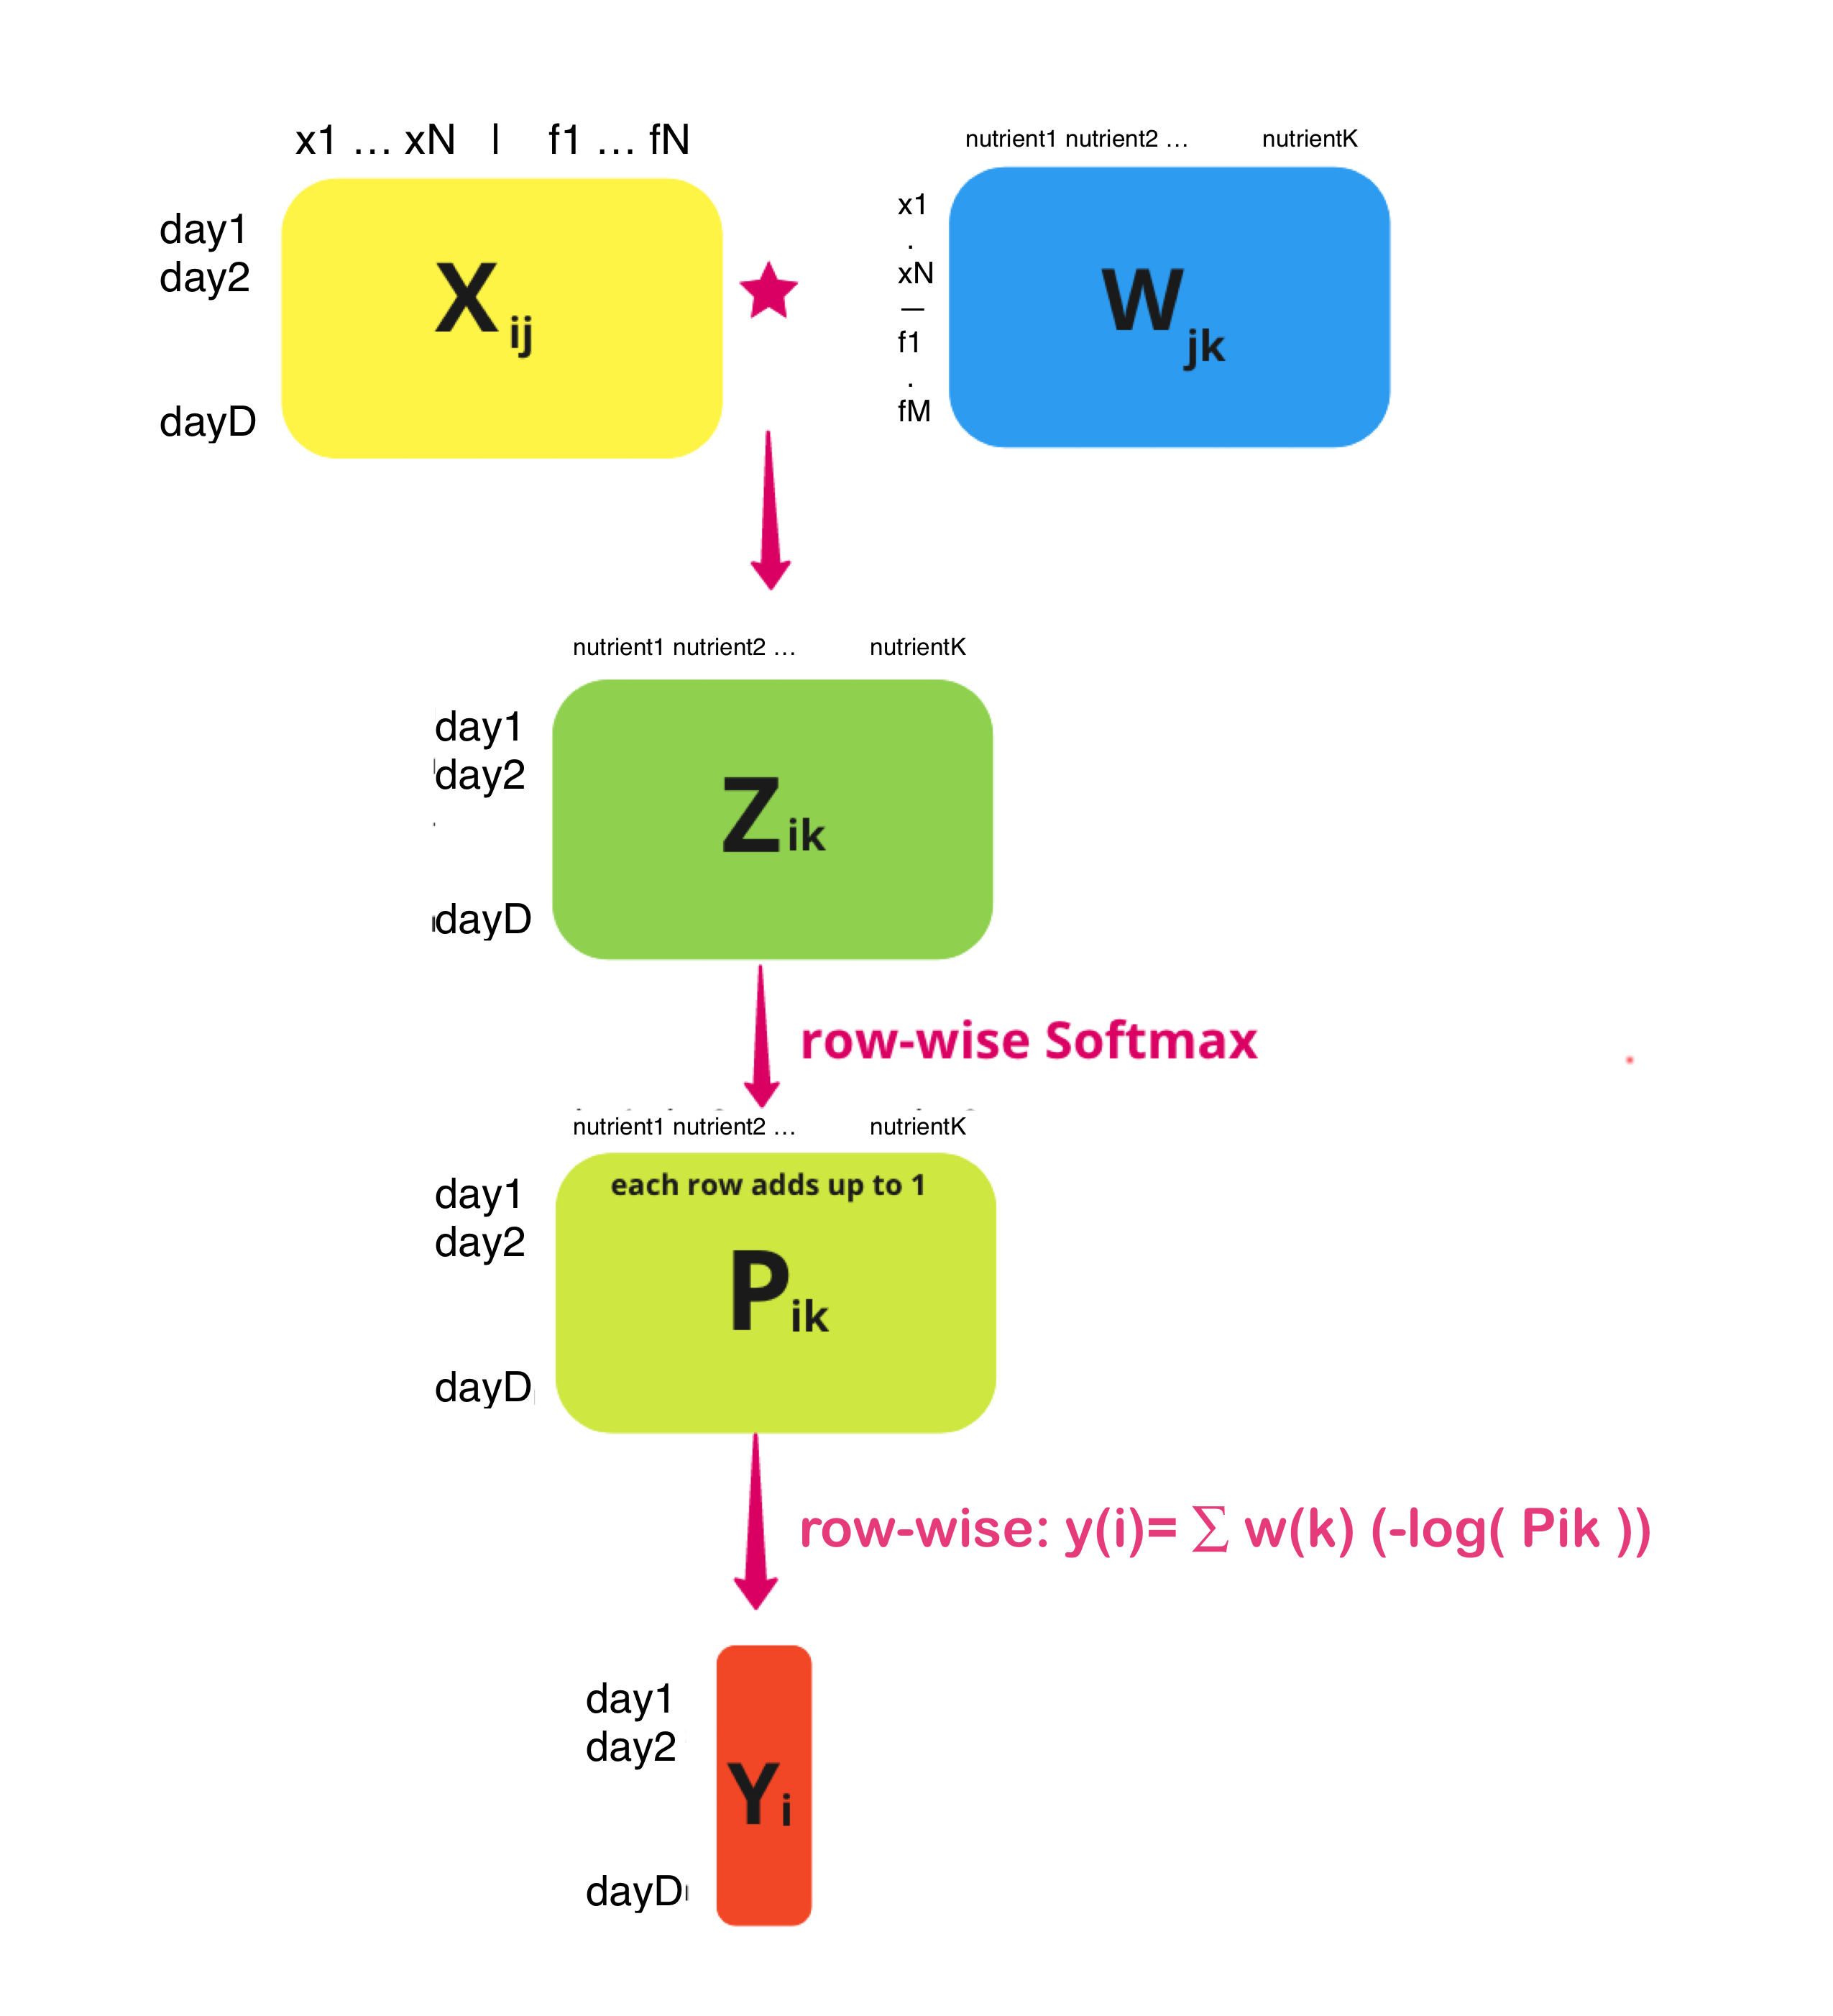

But for the entire problem solution.  Key ideas are: W matrix above is shared.  Outputs y are used to predict whether any of the imbalance measures are above zero. The equation in the figure is almost appropriate to predict one of the 4 imbalance measures.  If you predict them independently, then 
$$\hat{q}_{il} = \max\left(0, \sum_k w_{lk} \left(-\log(P_{ik})\right)\right)$$ with $l$ indexing the four imbalance/toxin measures can provide appropriate estimates. Note this is a two layer network, and that I forgot to add a box for the second set of weights!